**TITLE:**
DSCI PROJECT

**INTRO:**

-> background + question 

DSCI100 is a course that introduces students to organization of data through code. Throughout the semester, numerous tools in the R programming language are taught, some of which allow for data to be visualized and others that help data get sorted into much more interpretable forms. To demonstrate these tools and skills gained. Generous peers from the earlier semesters compiled a data frame which we can now use to develop some questions we may have about video games and their audience. The data frame that will be used includes information about the players' experience, subscription to a games related newsletter, hashed email, played hours, name, gender, and age. A research question that may arise from this set of data may be "Can age and hours played predict whether or not that person is subscribed to a game related newsletter?"

-> data description

In order to utilize the data, we can first select the columns of data that are actually relevant to the question which in this case, would be  "Age", "played_hours", and "subscribe". "Age" and "played_hours" act as explanatory variables while "subscribe" will be the response variable. Following the selection of our data, we should change our non numerical data into factors (fct). In the original data set, the column "subscribe" is identified as a string of characters (chr), to change this, the column can be mutated using as_factor() to convert the values into factors (fct). Making this change allows the program to properly identify "subscribe" as a category with a fixed set of groups instead of a set of continuous values. As for "played_hours" and "Age", they can stay as double (dbl) values which are meant for numeric values.

In [33]:
library(tidyverse)
library(repr)
library(tidymodels)

data <- read_csv("https://raw.githubusercontent.com/drsqs257/dsci-project/refs/heads/main/players.csv") |>
    select(subscribe, played_hours, Age) |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(Age != 'NA')
head(data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


Within the data to be used certain information about the data frame can be collected to help familiarize ourselves with the data. Let's take the number of observations/students into account. 

In [4]:
total_number_of_students_in_data <- nrow(data)
total_number_of_students_in_data 

[1] 196

Other pieces of information we can extract include things like the mean hours played across all the participants 

In [9]:
mean_hours <- data |>
    summarise(mean_hours = mean(played_hours))
mean_hours

mean_hours
<dbl>
5.845918


or the mean age.

In [10]:
mean_age <- data |>
    filter(Age != 'NA') |>
    summarise(mean_age = mean(Age))
mean_age

mean_age
<dbl>
20.52062


**METHOD**

-> data frame:

Thanks to how the data has been selected and mutated, all necessary columns have already been collected and all unnecessary columns are removed. From here, we can create a simple visualization to see how this data looks so far. While making this plot, it should also be noted that the "hours" are log scaled because of the wide-ranging values. Scaling it will make the model more stable and outliers less dominating.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


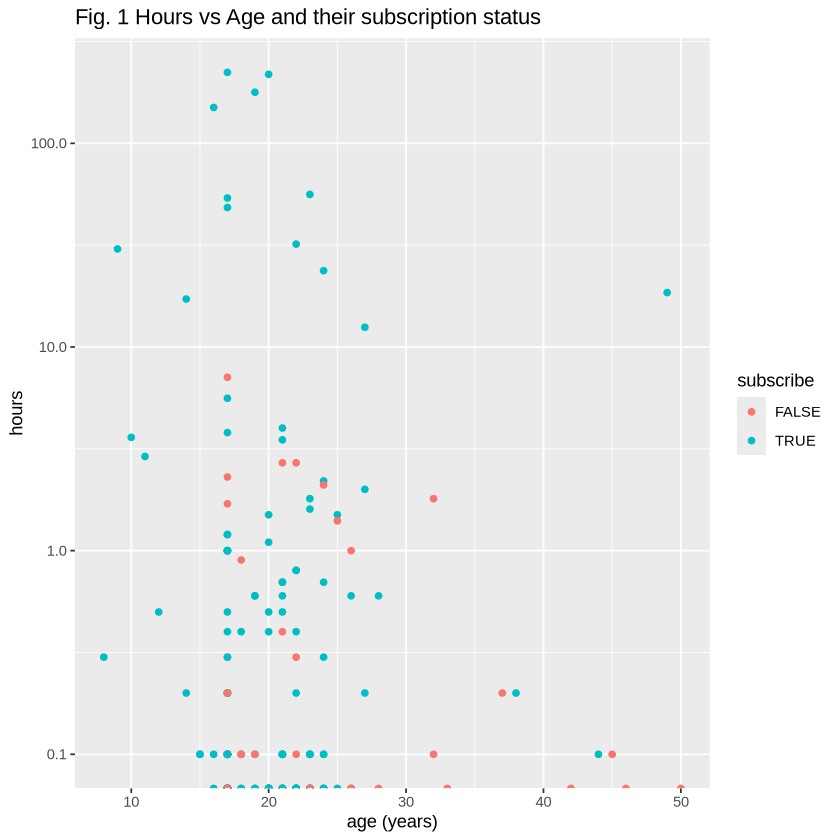

In [51]:
exp_plot <- data |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point()+
    labs(x = "age (years)" , y = "hours", color = "subscribe", title = "Fig. 1 Hours vs Age and their subscription status") +
    scale_y_log10()
exp_plot

Now, to actually attempt to answer the research question at hand, it will be approached as any other KNN classification problem we've ever seen. From Fig 1., it is clear that there is no distinct or easily recognizable linear relationship between the variables and not much of a pattern involving "subscribe". Knowing this, KNN becomes a good way to approach this question as it does well in working with data that does not have a linear pattern. Additionally, this question is a clear classification problem as it works to categorize the participants into one of two groups, those who have subscribed and those who haven't based on their hours played and age.


In [59]:
data_split <- initial_split(data, prop = 0.7, strata = subscribe)
data_train <- training(data_split)
data_test <- testing(data_split)

data_recipe <- recipe(subscribe ~ Age + played_hours, data = data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

vfold <- vfold_cv(data_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

workflow <- workflow() |>
    add_recipe(data_recipe)|>
    add_model(knn_tune) |>
    tune_grid(resamples = vfold, grid = k_vals)

knn_results <- collect_metrics(workflow)

accuracies <- knn_results |>
    filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5764347,5,0.04335938,Preprocessor1_Model01
2,accuracy,binary,0.5764347,5,0.04335938,Preprocessor1_Model02
3,accuracy,binary,0.5997558,5,0.03636011,Preprocessor1_Model03
4,accuracy,binary,0.6074481,5,0.03384497,Preprocessor1_Model04
5,accuracy,binary,0.6071836,5,0.02815463,Preprocessor1_Model05
6,accuracy,binary,0.6068987,5,0.03566383,Preprocessor1_Model06
7,accuracy,binary,0.6821327,5,0.02812981,Preprocessor1_Model07
8,accuracy,binary,0.6821327,5,0.02812981,Preprocessor1_Model08
9,accuracy,binary,0.6895401,5,0.01549766,Preprocessor1_Model09


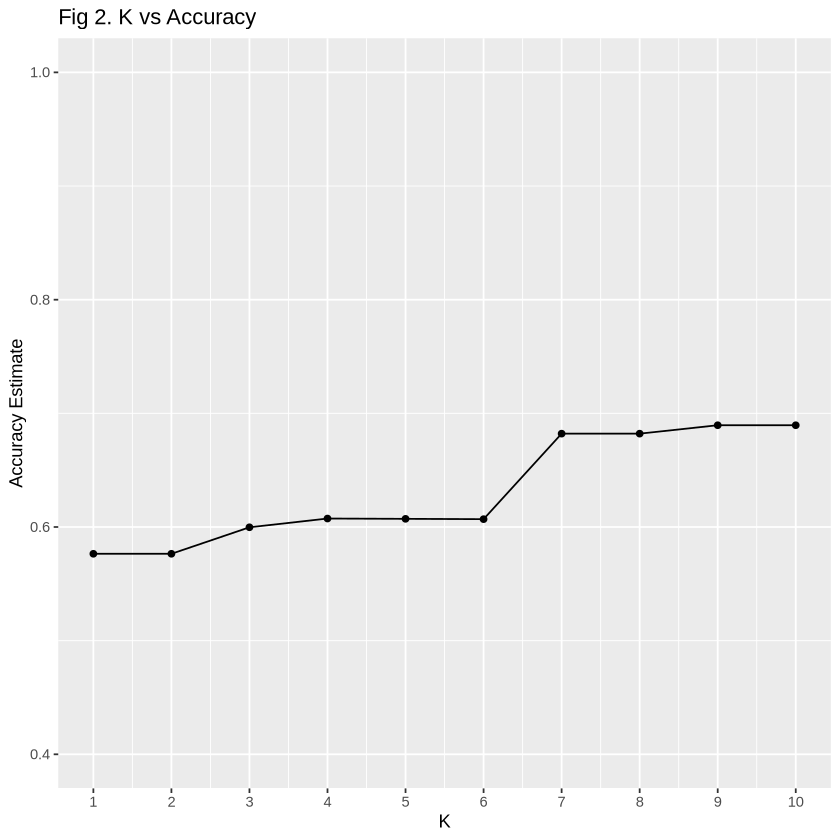

In [60]:
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()+
    labs(x = "K", y = "Accuracy Estimate", title = "Fig 2. K vs Accuracy") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) + 
    scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k
